In [26]:
!git clone https://github.com/patilsaklesh/Skin_Cancer_Classification_CNN.git
%cd Skin_Cancer_Classification_CNN

Cloning into 'Skin_Cancer_Classification_CNN'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
Receiving objects: 100% (12/12), 10.07 KiB | 10.07 MiB/s, done.
Resolving deltas: 100% (3/3), done.
remote: Total 12 (delta 3), reused 7 (delta 2), pack-reused 0 (from 0)
/content/Skin_Cancer_Classification_CNN/Skin_Cancer_Classification_CNN/Skin_Cancer_Classification_CNN


In [27]:
from google.colab import files
uploaded = files.upload()


Saving dataset.zip to dataset.zip


In [28]:
import zipfile
import os
import io

with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")



In [29]:
!ls /content


dataset  sample_data  Skin_Cancer_Classification_CNN


In [30]:
!ls /content/dataset

dataset  test  train


In [31]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

from sklearn.metrics import classification_report,confusion_matrix

In [35]:
# Paths
BASE_DIR = "/content/dataset/dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

In [36]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [37]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    directory=TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

print("Class Mapping:", train_generator.class_indices)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Class Mapping: {'Benign': 0, 'Malignant': 1}


In [38]:
from tensorflow.keras import layers,models

model=models.Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
early_stopping=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_schedular=ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    factor=0.3,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//BATCH_SIZE,
    epochs=30,
    validation_data=test_generator,
    validation_steps=test_generator.samples//BATCH_SIZE,
    callbacks=[early_stopping,lr_schedular]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 150s 383ms/step - accuracy: 0.7235 - loss: 0.6288 - val_accuracy: 0.7863 - val_loss: 0.4209 - learning_rate: 0.0010
Epoch 2/30
  1/371 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.8438 - loss: 0.4368

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8438 - loss: 0.4368 - val_accuracy: 0.8211 - val_loss: 0.3812 - learning_rate: 0.0010
Epoch 3/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 202s 407ms/step - accuracy: 0.8145 - loss: 0.4120 - val_accuracy: 0.8624 - val_loss: 0.3445 - learning_rate: 0.0010
Epoch 4/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8438 - loss: 0.3087 - val_accuracy: 0.8755 - val_loss: 0.3447 - learning_rate: 0.0010
Epoch 5/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 202s 415ms/step - accuracy: 0.8295 - loss: 0.3805 - val_accuracy: 0.8538 - val_loss: 0.3421 - learning_rate: 0.0010
Epoch 6/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.8125 - loss: 0.3951 - val_accuracy: 0.8528 - val_loss: 0.3437 - learning_rate: 0.0010
Epoch 7/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 202s 428ms/step - accuracy: 0.8345 - loss: 0.3730 - val_accuracy: 0.8311 - val_loss: 0.3694 - learning_rate: 0.0010
Epoch 8/30
371/371 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8438 - loss: 0.3321 

In [40]:
model.save("skin_cancer_cnn.h5")


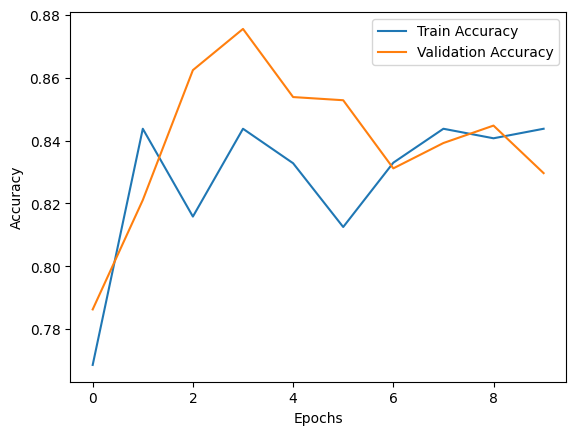

In [41]:

# Plot Training History
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.56      0.53      1000
           1       0.50      0.45      0.48       984

    accuracy                           0.51      1984
   macro avg       0.51      0.51      0.51      1984
weighted avg       0.51      0.51      0.51      1984



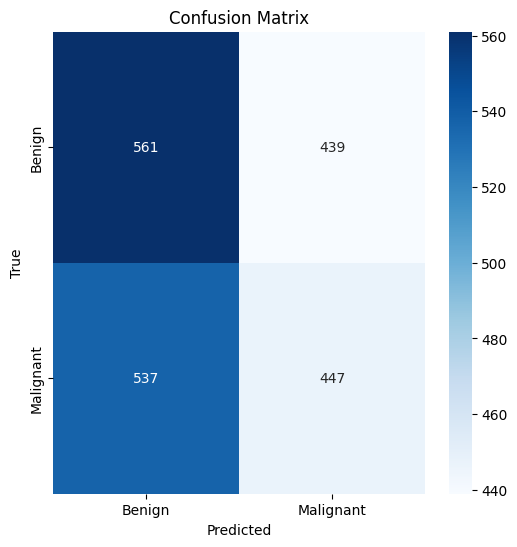

In [42]:
# Predict on the test set
test_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)

# Convert predictions to binary labels (0 or 1)
test_pred_labels = (test_pred > 0.5).astype("int32")

# Get the true labels
test_true_labels = test_generator.classes[:len(test_pred_labels)]  # Match length to predictions

# Classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_pred_labels))

# Confusion Matrix
cm = confusion_matrix(test_true_labels, test_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [44]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('skin_cancer_cnn.h5')


def predict_skin_cancer(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))  # Load Image
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make Prediction
    prediction = model.predict(img_array)
    class_label = "Malignant" if prediction > 0.5 else "Benign"

    # Show Image with Prediction
    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis("off")
    plt.show()